# Stream simulation examples

We provide some examples for using the `stream` package for running simulations of GD-1. Simulations are made using the code `stream.simulate()`, which returns a list of phase space trajectories for $N$ stars. By default, `stream.simulate()` runs a simulation with default parameters, including a single perturbing subhalo described by the Bonaca-Hernquist profile.

Another useful module is the `coordinates` module, which transforms from galactocentric coordinates to celestial coordinates (especially, the sky positions $\phi_1$-$\phi_2$).

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd

import stream

In [23]:
# Simulation with default parameters (Bonaca-Hernquist subhalo perturber)

trajectories = stream.simulate()
pos = stream.coordinates.transform(trajectories)

## Simulation outputs

Here we plot the position of the stream on the sky

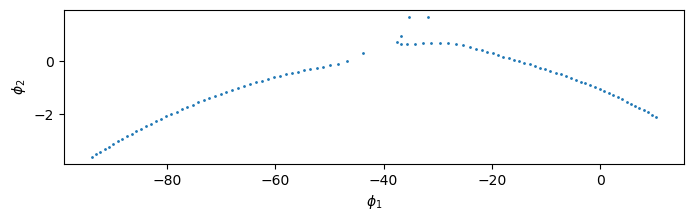

In [24]:
plt.figure(figsize=(8,2))

plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.show()

## Subhalo profiles

Alternative profiles can be specified using the keyword `subhalo_profile_type`. 
Currently the following profiles are allowed:
- tNFW (`subhalo_profile_type='tNFW'`): Also needs keyword `M_subhalo` to be set.
- Hernquist (`subhalo_profile_type='Hern')`: Also needs keyword `M_subhalo` to be set.
- SIDM from Jeans model (`subhalo_profile_type='Jeans')`: Also needs keywords `M_subhalo` and `sigma_m` to be set.
- SIDM5 from numerical grid of profile data (`subhalo_profile_type='SIDM5')`: Also needs keywords `M_subhalo`.
- Custom numerical profile (`subhalo_profile_type='numerical'`): Also needs keywords `M` and `r` to be set, as equal-length arrays.

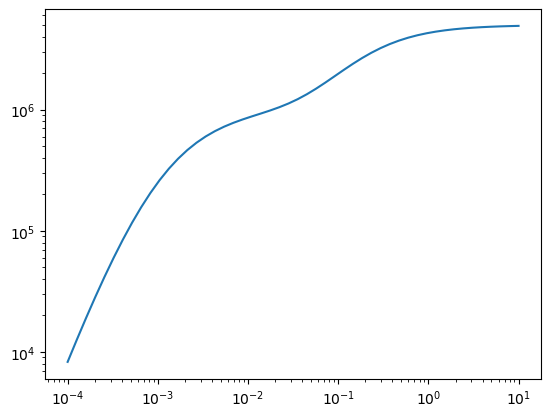

In [25]:
# Example numerical profile
r = np.logspace(-4,1)
M = 4e6 * r**2 / (r + 0.1)**2 + 1e6 * r**2 / (r + 0.001)**2
plt.loglog(r,M)

In [26]:
subhalo_params = {'subhalo_profile_type':'numerical','M':M,'r':r}
trajectories = stream.simulate(**subhalo_params)
pos = stream.coordinates.transform(trajectories)

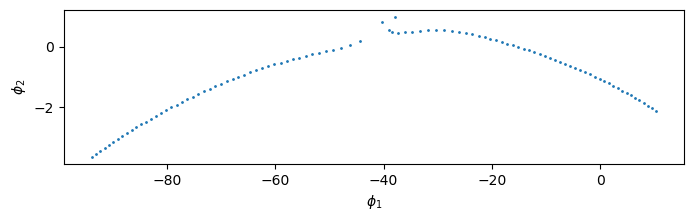

In [27]:
plt.figure(figsize=(8,2))

plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.show()

## Multiprocessing

By default, `stream.simulate()` makes a linear uniformly-distributed stream. A more realistic stream can be made by setting the keyword `star_distribution='random'`. One can also increase the number of stars by setting the `num_stars` keyword (the default is 100). 

The simulation time increases with the number of stars. This can be circumvented by running multiple simulations in parallel and combining the results into one stream. Remember to set `random_seed` to be different for each parallel process, otherwise you will get copies of the same random stream.

Here we will get a respectable stream of 2000 stars by running 8 simulations in parallel.

In [28]:
inputs = [{'star_distribution':'random','random_seed':n, 'num_stars':250} for n in range(8)]

# inputs = [{'star_distribution':'random',
#            'random_seed':n,
#            'subhalo_profile_type':'SIDM5',
#            'M_subhalo':1e7,
#            'num_stars':250} for n in range(8)]

num_processes = 8

# Divide one stream simulation into parallel simulations
with Pool(num_processes) as p:
    output = p.map(stream.simulate,inputs)
    
# Put all trajectories together
trajectories = np.concatenate(output)
pos = stream.coordinates.transform(trajectories)

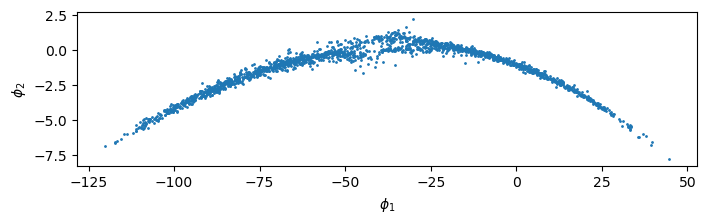

In [29]:
plt.figure(figsize=(8,2))

plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.show()

## More input parameters

There are many inputs that can be entered into `stream.simulate()` as keyword arguments. Running in verbose-mode can provide some guidance.

In [15]:
trajectories = stream.simulate(verbose=True)

run parameters:
('dense_output', False)
('rtol', 1e-08)
('atol', 1e-08)
('verbose', True)

main stream parameters:
('num_stars', 100)
('star_distribution', 'linear')
('final_pos', array([-9.01980644,  6.33880098,  8.78898523]))
('final_vel', array([-160.8473684 , -218.61793999,  -56.47907773]))
('stream_pos_width', 0)
('stream_vel_width', None)
('t0', -2)
('tf', 0)
('random_seed', 5)

MW parameters:
('MW_model_type', 'general')
('M_disk', 55000000000.0)
('a_disk', 3)
('b_disk', 0.28)
('M_bulge', 4000000000.0)
('h_bulge', 1)
('rhos_halo', 12913410.372338967)
('rs_halo', 15.62)

subhalo parameters for subhalo 0:
('subhalo_profile_type', 'Bonaca_Hern')
('impact_position', 0.51)
('v_subhalo', 280)
('b_impact_param', 0.015)
('theta_impact', 1.665)
('phi_impact', 1.15)
('t_since_impact', 0.545)



time ellapsed = 10.466358423233032


Here we consider varying the age of the halo. This is done by setting a keyword argument `t0=-tage`, i.e. the final time is at $t_f=0$ and the initial time is at $t_0 = - t_{\rm age}$. Valid ages are integers in the range `range(1,11)`, i.e. values between 1-10 Gyr (inclusive).

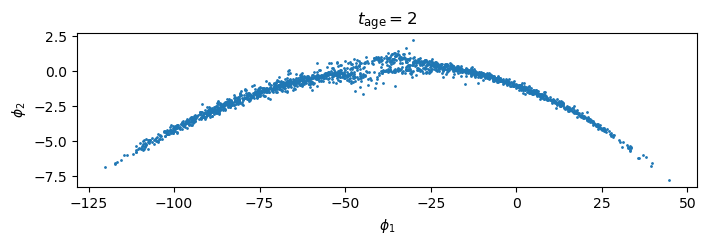

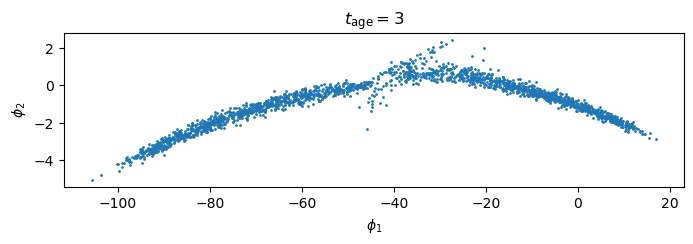

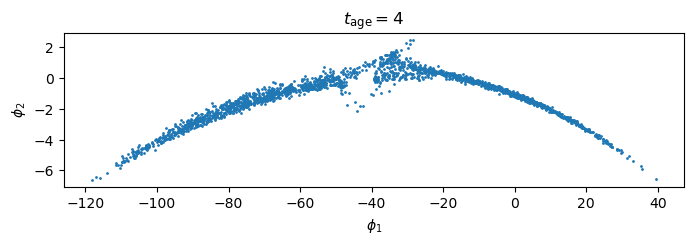

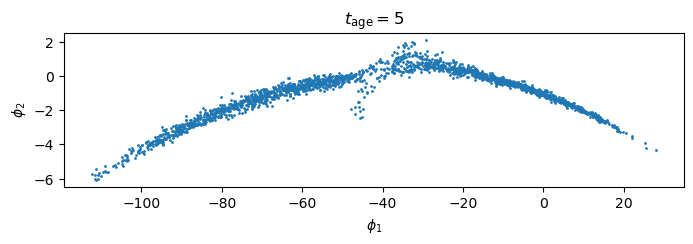

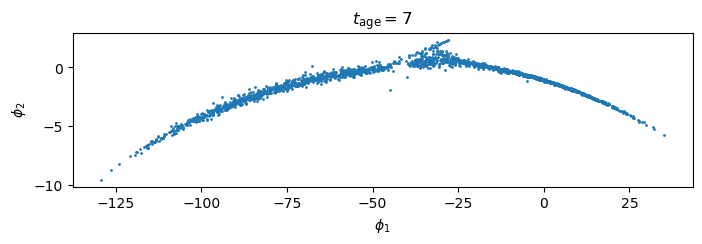

In [16]:
for tage in [2,3,4,5,7]:
    
    inputs = [{'star_distribution':'random','random_seed':n, 'num_stars':250, 't0':-tage} for n in range(8)]

    num_processes = 8
    with Pool(num_processes) as p:
        output = p.map(stream.simulate,inputs)
    
    trajectories = np.concatenate(output)
    pos = stream.coordinates.transform(trajectories)

    plt.figure(figsize=(8,2))

    plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

    plt.xlabel(r'$\phi_1$')
    plt.ylabel(r'$\phi_2$')
    plt.title(r'$t_{\rm age}=$%d' % tage)
    plt.show()

In [30]:
# Import data from the file Multiple_subhalo_impacts_samples.csv
# Only subhalos with t_since_impact < 2 Gyr are selected
data = pd.read_csv('Multiple_subhalo_impacts_samples.csv')

# Chose section of the data
num_data = 0

# Select data (for num_data and t_since_impact <=2 Gyr)
filtered_data = data[(data['num'] == num_data) & (data['t_since_impact'] <= 2)]

data = pd.read_csv('Multiple_subhalo_impacts_samples.csv')
M_subhalo = data['M_subhalo'].values
impact_position = data['fimp'].values
b_impact_param = data['b'].values
t_since_impact = data['t_since_impact'].values
delta_logc = data['delta_logc'].values
phi_impact = data['phi'].values
theta_impact = data['theta'].values
v_subhalo = data['v_subhalo'].values

# Print data
print(filtered_data)

    Unnamed: 0  num     M_subhalo      fimp  t_since_impact  delta_logc  \
0            0    0  1.317388e+05  0.525303        0.687750   -0.070731   
12          12    0  8.300283e+06  0.040260        0.382800    0.075635   
19          19    0  5.306387e+06  0.133996        1.264391    0.106481   
23          23    0  1.791530e+05  0.829098        0.818049    0.026839   
31          31    0  2.399791e+05  0.549835        0.749232    0.111589   
32          32    0  1.065272e+05  0.002292        0.126421   -0.071454   
34          34    0  6.282070e+06  0.892871        1.515616    0.000112   
36          36    0  2.148527e+05  0.471946        0.660531    0.004537   
38          38    0  1.714696e+05  0.753251        1.269922   -0.098629   
41          41    0  1.297345e+05  0.681287        0.694162    0.052968   
45          45    0  1.105812e+05  0.354214        1.720204   -0.025089   

     v_subhalo         b       phi     theta      bmax  
0   417.273403  0.002020  5.154647  1.8399

In [34]:
subhalo_list = []

for _, row in filtered_data.iterrows():
    subhalo = {
        'M_subhalo': row['M_subhalo'],
        'impact_position': row['fimp'],
        'b_impact_param': row['b'],
        't_since_impact': row['t_since_impact'],
        'delta_logc': row['delta_logc'],
        'phi_impact': row['phi'],
        'theta_impact': row['theta'],
        'v_subhalo': row['v_subhalo']
    }
    subhalo_list.append(subhalo)

for subhalo in subhalo_list:
    subhalo['subhalo_profile_type'] = 'Hern'

tr = stream.simulate(subhalo_list=subhalo_list,verbose=True)

run parameters:
('dense_output', False)
('rtol', 1e-08)
('atol', 1e-08)
('verbose', True)

main stream parameters:
('num_stars', 100)
('star_distribution', 'linear')
('final_pos', array([-9.01980644,  6.33880098,  8.78898523]))
('final_vel', array([-160.8473684 , -218.61793999,  -56.47907773]))
('stream_pos_width', 0)
('stream_vel_width', None)
('t0', -2)
('tf', 0)
('random_seed', 5)

MW parameters:
('MW_model_type', 'general')
('M_disk', 55000000000.0)
('a_disk', 3)
('b_disk', 0.28)
('M_bulge', 4000000000.0)
('h_bulge', 1)
('rhos_halo', 12913410.372338967)
('rs_halo', 15.62)

subhalo parameters for subhalo 0:
('M_subhalo', 131738.7857)
('impact_position', 0.525303132)
('b_impact_param', 0.002019588)
('t_since_impact', 0.687749813)
('delta_logc', -0.070730866)
('phi_impact', 5.154647414)
('theta_impact', 1.839908543)
('v_subhalo', 417.2734028)
('subhalo_profile_type', 'Hern')
('subhalo_list', [{'M_subhalo': 131738.7857, 'impact_position': 0.525303132, 'b_impact_param': 0.002019588, 't_

subhalo parameters for subhalo 4:
('M_subhalo', 239979.1419)
('impact_position', 0.549835154)
('b_impact_param', 0.163564547)
('t_since_impact', 0.749232284)
('delta_logc', 0.111589249)
('phi_impact', 6.21331712)
('theta_impact', 2.100859675)
('v_subhalo', 203.9879161)
('subhalo_profile_type', 'Hern')
('subhalo_list', [{'M_subhalo': 131738.7857, 'impact_position': 0.525303132, 'b_impact_param': 0.002019588, 't_since_impact': 0.687749813, 'delta_logc': -0.070730866, 'phi_impact': 5.154647414, 'theta_impact': 1.839908543, 'v_subhalo': 417.2734028, 'subhalo_profile_type': 'Hern'}, {'M_subhalo': 8300282.895, 'impact_position': 0.040260486, 'b_impact_param': 0.236528382, 't_since_impact': 0.382800213, 'delta_logc': 0.075635154, 'phi_impact': 4.602187824, 'theta_impact': 1.88452867, 'v_subhalo': 285.0586175, 'subhalo_profile_type': 'Hern'}, {'M_subhalo': 5306386.767, 'impact_position': 0.133995886, 'b_impact_param': 0.300902908, 't_since_impact': 1.26439144, 'delta_logc': 0.106481437, 'phi_i

subhalo parameters for subhalo 8:
('M_subhalo', 171469.5734)
('impact_position', 0.753250574)
('b_impact_param', 0.168065529)
('t_since_impact', 1.269922344)
('delta_logc', -0.0986292)
('phi_impact', 1.884871212)
('theta_impact', 0.926141226)
('v_subhalo', 227.6563597)
('subhalo_profile_type', 'Hern')
('subhalo_list', [{'M_subhalo': 131738.7857, 'impact_position': 0.525303132, 'b_impact_param': 0.002019588, 't_since_impact': 0.687749813, 'delta_logc': -0.070730866, 'phi_impact': 5.154647414, 'theta_impact': 1.839908543, 'v_subhalo': 417.2734028, 'subhalo_profile_type': 'Hern'}, {'M_subhalo': 8300282.895, 'impact_position': 0.040260486, 'b_impact_param': 0.236528382, 't_since_impact': 0.382800213, 'delta_logc': 0.075635154, 'phi_impact': 4.602187824, 'theta_impact': 1.88452867, 'v_subhalo': 285.0586175, 'subhalo_profile_type': 'Hern'}, {'M_subhalo': 5306386.767, 'impact_position': 0.133995886, 'b_impact_param': 0.300902908, 't_since_impact': 1.26439144, 'delta_logc': 0.106481437, 'phi_i



time ellapsed = 34.41871166229248


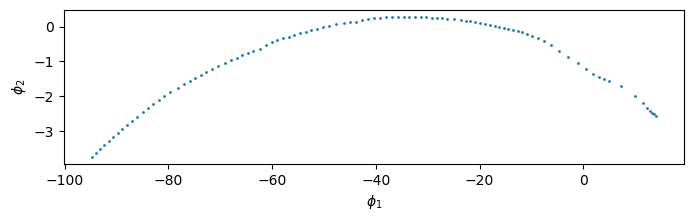

In [36]:
pos = stream.coordinates.transform(tr) # changed to tr

plt.figure(figsize=(8,2))

plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.show()

In [37]:
# Export data to insert in the power spectrum code
# The section of the data (= num_data) is written in the data name ("data0", "data1", etc.)
data_power_spectrum = pd.DataFrame(pos['phi1'], columns=['x'])
filename = f'data{num_data}.csv'

# Save data
data_power_spectrum.to_csv(filename, index=False) 